# Normalized concatenated feature data from multiple sources

(2321, 3168)


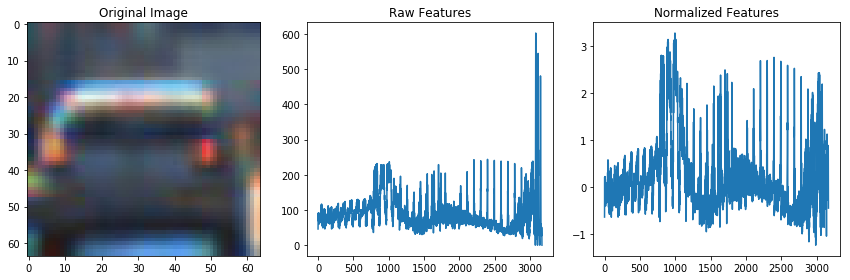

In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob

%matplotlib inline

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def load_and_convert(file_name, cspace):
    # apply color conversion if other than 'RGB'
    image = mpimg.imread(fname=file_name)
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    else: feature_image = np.copy(image)
        
    return feature_image

###### TODO ###########
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img_fn in imgs:
        # Read in each one by one
        img = load_and_convert(img_fn, cspace)
        # apply color conversion if other than 'RGB'
        # Apply bin_spatial() to get spatial color features
        bin_spat_res = bin_spatial(img, size=spatial_size)
        # Apply color_hist() to get color histogram features
        color_hist_res = color_hist(img, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        
        conc = np.concatenate((bin_spat_res, color_hist_res))
        
        features.append(conc)
        
    # Return list of feature vectors
    return features

images = glob.glob('./../data/1_20_Object_Detection/classify_smallset/**/*.jpeg', recursive=True)

cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)        
    
    print(X.shape)
    
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')